# Predicting Sentiment of Movie Reviews from Critics

Kaggle Link: https://www.kaggle.com/datasets/stefanoleone992/rotten-tomatoes-movies-and-critic-reviews-dataset?select=rotten_tomatoes_critic_reviews.csv

Github Link: https://github.com/anuronmitra2001/M508C_Big-Data-Analysis_Folder

# Problem Statement

A Streaming platform receives large amount of movie review data from critics and its very difficult to manually classify whether the movie review is fresh or rotten. The company aims to automatically determine the critic sentiment from the reviews, which would help them in acquiring, promoting or recommending movies based on critical perception.

### Benefit to the Company

An automated system to determine review sentiment would help the company to:

1. Quickly identify positively or negatively reviewed movies.
2. Marketing and promoting decisions.
3. Help in content acquisition and recommendation strategies.

### Data Collection

Data can be collected from sites like rotten tomatoes, imdb, metacritic etc. and use this to train a model.

### Formulating the Problem as an NLP Task

The problem can be formulated as a supervised sentiment classification task with the critic reviews as the independent variable and the review type as the target variable (fresh or rotten), the steps are:

1. Text preprocessing and conversion to tokens
2. Token conversion to numerical embeddings using models like tfidf or GRU
3. Training using a classification model
4. Validation and testing on unseen critic reviews.

# High Level System Design

### Main Components of the NLP system and their usefullness:

1. Exploratory Data Analysis: This step is for checking data quality issues like missing values count, if the data is balanced or not and to get an overall idea of the word counts and character lengths.
2. Data Preprocessing: This step is for preparing the dataset for model input by splitting the data into training, validation and test sets, label encoding the target variables, handling class imbalance, normalising the text and conversion to tokens.
3. Feature Representation: This step is used for converting tokens into numerical representations with the use of TF-IDF or embeddings that will be required for machine learning and deep learning models.
4. Model Training: The model was trained using the numerical text data with label-encoded review-type data.
5. Evaluation: Validating and testing the model on unseen data and the using evaluation metrics, such as accuracy score, recall score, precision score, F1 score, and ROC-AUC score, to check how efficiently the model is able to determine sentiments of reviews.


In [ ]:
from google.colab import drive
data_dir = drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np
import random
import os
import nltk, re, string, spacy
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score,classification_report,confusion_matrix,roc_auc_score,ConfusionMatrixDisplay,precision_score,f1_score,recall_score
from sklearn.utils import compute_class_weight
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from wordcloud import WordCloud,STOPWORDS
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize,RegexpTokenizer
from imblearn.over_sampling import RandomOverSampler
import torch
from transformers import BertTokenizer, AutoModelForSequenceClassification,get_linear_schedule_with_warmup, Trainer, TrainingArguments
from torch.optim import AdamW
from tqdm import tqdm
from datasets import Dataset
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import callbacks
from tensorflow.keras import Sequential,layers
from tensorflow.keras.layers import Embedding, GRU, Dense,Dropout,SpatialDropout1D
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping,ReduceLROnPlateau
from tensorflow.keras.regularizers import l2
nltk.download('stopwords')
nltk.download('punkt_tab')

device = 'cuda' if torch.cuda.is_available() else 'cpu'

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


In [ ]:
random.seed(42)
np.random.seed(42)
tf.random.set_seed(42)
os.environ['TF_DETERMINISTIC_OPS'] = '1'
os.environ['TF_CUDNN_DETERMINISTIC'] = '1'
os.environ['PYTHONHASHSEED'] = '42'

In [ ]:

data = pd.read_csv('/content/drive/MyDrive/Rotten_Tomatoes_Reviews/rotten_tomatoes_critic_reviews.csv')
len(data)

1130017

In [ ]:
df = data.groupby('review_type', group_keys = False).apply(lambda x:x.sample(frac = 200000/len(data), random_state = 42)).reset_index(drop = True)
df.head()

/tmp/ipython-input-2834647973.py:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = data.groupby('review_type', group_keys = False).apply(lambda x:x.sample(frac = 200000/len(data), random_state = 42)).reset_index(drop = True)


,rotten_tomatoes_link,critic_name,top_critic,publisher_name,review_type,review_score,review_date,review_content
0,m/throw_momma_from_the_train,Scott Weinberg,False,eFilmCritic.com,Fresh,4/5,2002-07-27,NaN
1,m/zodiac,NaN,False,The Sun (UK),Fresh,4/5,2007-08-08,Downey steals the show with yet another inspir...
2,m/passion_of_the_christ,Jeffrey Overstreet,False,Looking Closer,Fresh,B+,2004-12-06,"An ambitious, great, and flawed film ... [it] ..."
3,m/star_wars_episode_iii_revenge_of_the_sith,JoBlo,False,JoBlo's Movie Network,Fresh,9/10,2005-05-17,My favorite of the three most recent Star Wars...
4,m/battle_for_haditha,Edward Douglas,False,ComingSoon.net,Fresh,7/10,2008-05-09,There's a size and scope to the film we haven'...


# Exploratory Data Analysis

In [ ]:
print('Size of Original Dataset: ',len(data))
print('Size of Sampled Dataset: ',len(df))

Size of Original Dataset:  1130017
Size of Sampled Dataset:  200000


In [ ]:
df.isnull().sum()

,0
rotten_tomatoes_link,0
critic_name,3230
top_critic,0
publisher_name,0
review_type,0
review_score,54306
review_date,0
review_content,11788


In [ ]:
df = df.dropna(subset = 'review_content')
len(df)

188212

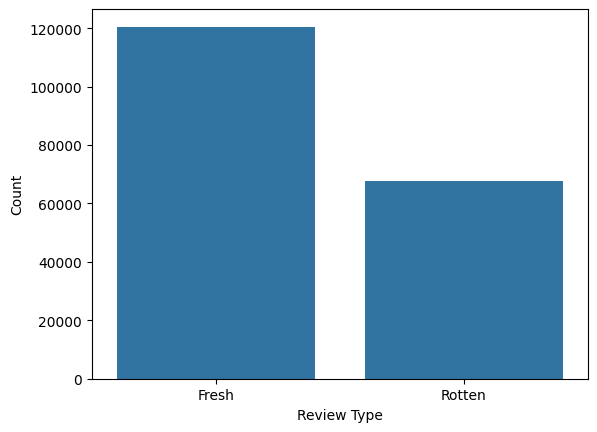

  review_type   count
0       Fresh  120487
1      Rotten   67725


In [ ]:
sns.countplot(data = df, x = 'review_type')
plt.xlabel('Review Type')
plt.ylabel('Count')
plt.show()
print(df['review_type'].value_counts().reset_index())

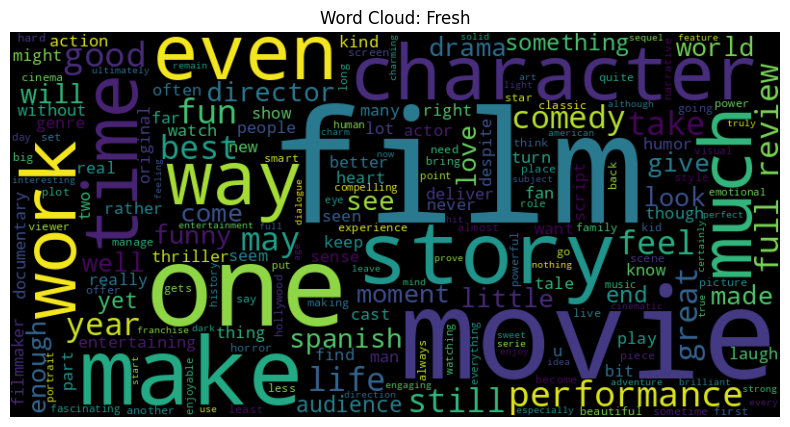

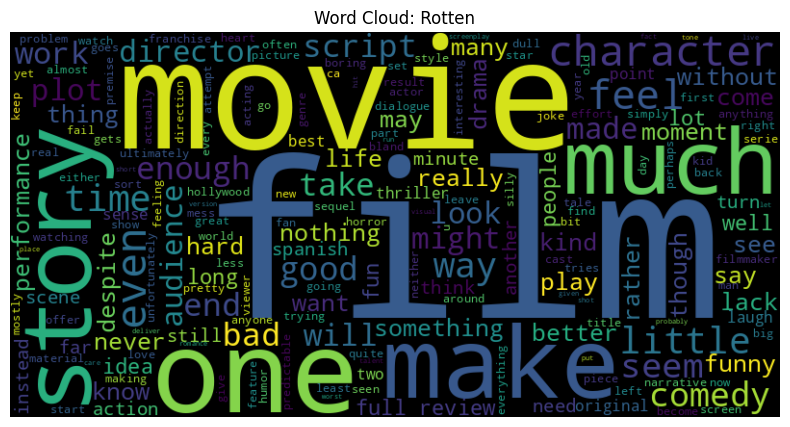

In [ ]:
for r in df['review_type'].unique():
    text = ' '.join(df[df['review_type'] == r]['review_content'].astype(str))
    words = word_tokenize(text.lower())
    cleaned_words = [w for w in words if w.isalpha() ]
    cleaned_text = ' '.join(cleaned_words)
    wordcloud = WordCloud(width = 800, height = 400).generate(cleaned_text)
    plt.figure(figsize = (10,5))
    plt.imshow(wordcloud, interpolation = 'bilinear')
    plt.title(f'Word Cloud: {r}')
    plt.axis('off')
    plt.show()

In [ ]:
df1 = pd.DataFrame()
df1['char_length'] = df['review_content'].astype(str).apply(len)
df1['word_count'] = df['review_content'].astype(str).apply(lambda x:len(word_tokenize(x)))
df1['review_type'] = df['review_type']

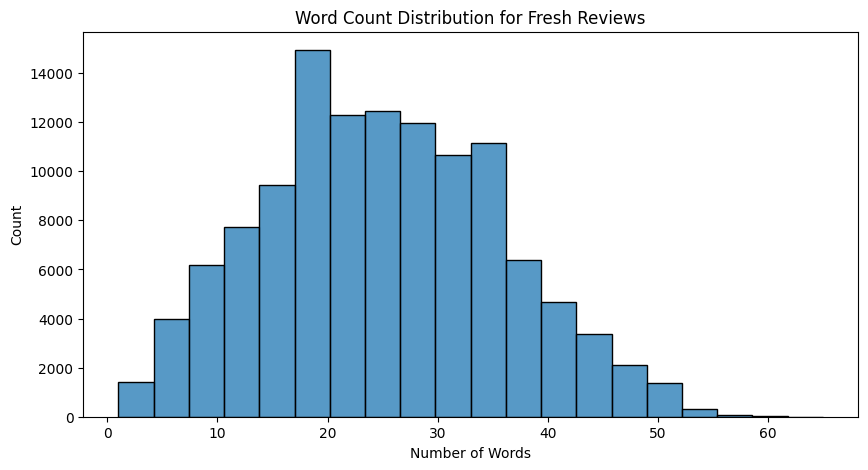

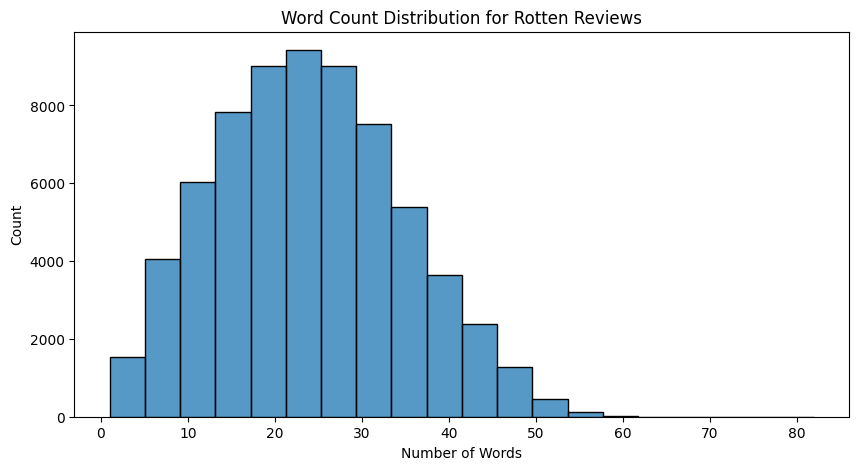

In [ ]:
for i in df1['review_type'].unique():
    plt.figure(figsize = (10,5))
    sns.histplot(data = df1[df1['review_type'] == i], x = 'word_count', bins = 20)
    plt.title(f'Word Count Distribution for {i} Reviews')
    plt.xlabel('Number of Words')
    plt.ylabel('Count')
    plt.show()

In [ ]:
df1.groupby('review_type')['word_count'].describe()

,count,mean,std,min,25%,50%,75%,max
review_type,,,,,,,,
Fresh,120487.0,24.888685,10.735305,1.0,17.0,25.0,32.0,65.0
Rotten,67725.0,24.204636,10.597527,1.0,16.0,24.0,31.0,82.0


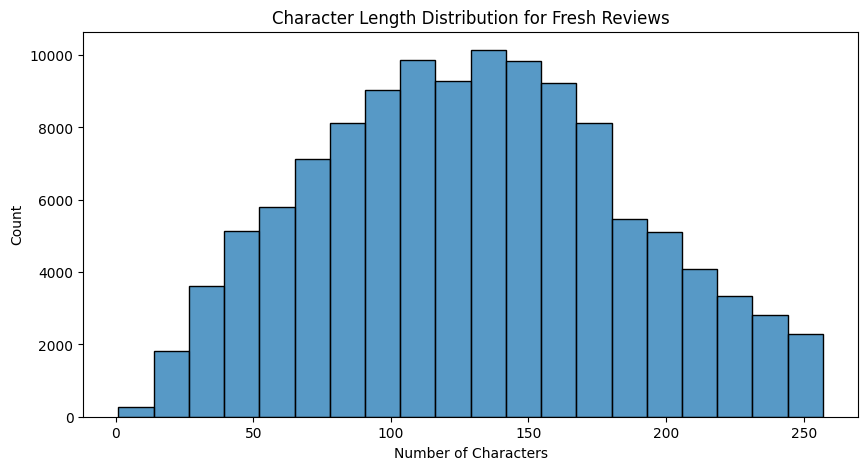

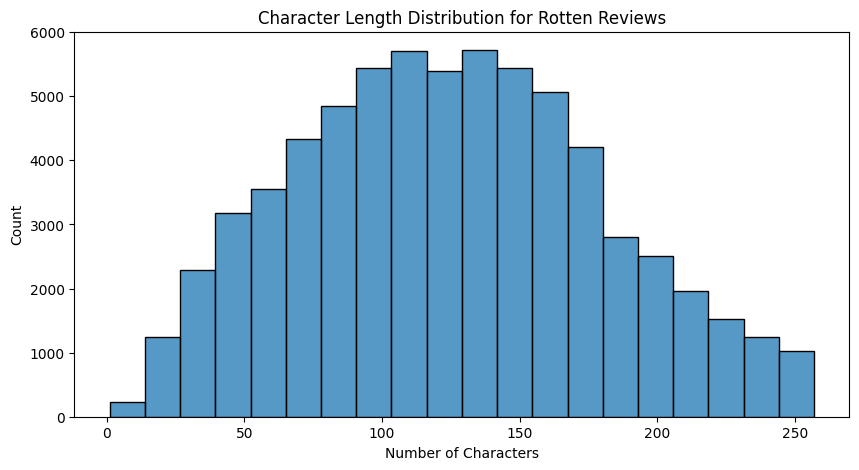

In [ ]:
for i in df1['review_type'].unique():
  plt.figure(figsize = (10,5))
  sns.histplot(data = df1[df1['review_type'] == i], x = 'char_length', bins = 20)
  plt.title(f'Character Length Distribution for {i} Reviews')
  plt.xlabel('Number of Characters')
  plt.ylabel('Count')
  plt.show()

In [ ]:
df1.groupby('review_type')['char_length'].describe()

,count,mean,std,min,25%,50%,75%,max
review_type,,,,,,,,
Fresh,120487.0,129.767079,55.718714,1.0,88.0,129.0,169.0,257.0
Rotten,67725.0,124.732255,54.859594,1.0,83.0,123.0,163.0,257.0


### Exploratory Data Analysis

1. A Sample of 200,000 data was taken using stratified sampling for proper represenation of both classes from 1,130,017 for faster text preprocessing and training.
2. Checked the data for missing values and removed any rows which didnt have any review content, as without any text further preprocessing cannot be applied.
3. Class distribution bar chart showed the difference in between the classes which shows that the data is moderately imbalanced and so class balancing techniques is needed.
4. Displayed the word clouds for fresh and rotten reviews and found out that:

-  Fresh Reviews had words like good, best, funny, entertaining, love which are words with a positive connotation.
-  Rotten Reviews had words like bad, never, end, despite, lack, which are words with a negative connotation.
-   Even though there are overlaps some of these words are common in one than the other.

5. Plotted histograms to display the word count and character length distribution for both review types which showed that the average and minimum count for both the review types were almost the same but the maximum word count for rotten reviews were more and the average character length for fresh reviews were longer than rotten reviews and the minimum and maximum length were same for both.





# Text Preprocessing

In [ ]:
X = df['review_content']
y = df['review_type']

In [ ]:
X_train_whole,X_test,y_train_whole,y_test = train_test_split(X,y,test_size = 0.2,stratify = y,random_state = 42)
X_train,X_val,y_train,y_val = train_test_split(X_train_whole,y_train_whole,test_size = 0.2,stratify = y_train_whole,random_state = 42)

In [ ]:
print(X_train.shape)
print(X_val.shape)
print(X_test.shape)

(120455,)
(30114,)
(37643,)


In [ ]:
le = LabelEncoder()
y_train_encoded = le.fit_transform(y_train)
y_val_encoded = le.transform(y_val)
y_test_encoded = le.transform(y_test)

In [ ]:
classes = np.unique(y_train_encoded)
class_weights = compute_class_weight(class_weight = 'balanced',classes = classes,y = y_train_encoded)
class_weight_dict = {i: weight for i, weight in zip(classes,class_weights)}
print(f'Calculated class weights: {class_weight_dict}')
class_weights_tensor = torch.tensor(class_weights,dtype = torch.float)
print('Class Weights for BERT: ',class_weights_tensor)

Calculated class weights: {np.int64(0): np.float64(0.7810493963247785), np.int64(1): np.float64(1.3895233480989295)}
Class Weights for BERT:  tensor([0.7810, 1.3895])


In [ ]:
stop_words = set(stopwords.words('english'))
tfidf_tokenizer = RegexpTokenizer(r'[a-zA-Z]+')
def clean_text(text):
    text = text.lower()
    text = re.sub(r'http\S+|www\S+|\S+\.com\S+',' ',text)
    text = re.sub(r'\s+', ' ', text).strip()
    tokens = tfidf_tokenizer.tokenize(text)
    tokens = [ t for t in tokens if t not in stop_words]
    return tokens

gru_tokenizer = RegexpTokenizer(r"[a-zA-Z']+")

def clean_text_gru(text):
  text = text.lower()
  text = re.sub(r'http\S+|www\S+|\S+\.com\S+',' ',text)
  text = re.sub(r'\s+', ' ', text).strip()
  tokens = gru_tokenizer.tokenize(text)
  return tokens

In [ ]:
nlp = spacy.load('en_core_web_sm')
def lemmatizer(clean_text):
    lemmatized = []
    for i in clean_text:
        text = ' '.join(i)
        doc = nlp(text)
        lemma = []
        for d in doc:
            lemma.append(d.lemma_)
        lemmatized.append(lemma)
    return(lemmatized)

In [ ]:
X_train_clean = pd.Series(X_train).apply(clean_text)
X_val_clean = X_val.apply(clean_text)
X_test_clean = X_test.apply(clean_text)

X_train_clean_gru = pd.Series(X_train).apply(clean_text_gru)
X_val_clean_gru = X_val.apply(clean_text_gru)
X_test_clean_gru = X_test.apply(clean_text_gru)

X_train_lem = lemmatizer(X_train_clean)
X_val_lem = lemmatizer(X_val_clean)
X_test_lem = lemmatizer(X_test_clean)

### Text Preprocessing

1. Assigned review content as X (independent variable) and review type as y (dependant variable) and performed train test split to divide the data into training, validation and testing.
2. The target labels were label encoded for use in machine learning and deep learning models.
3. Class weights were calculated using balanced strategy and converted into a dictionary and PyTorch Tensor for class imbalance handling during model training.  
4. 2 seperate functions were created which are almost the same which makes all the words lowercase, removes additional whitespaces, removes URLs, special characters and numbers and converts the text into tokens but for GRU the stopwords and apostrophes are not removed to maintain the sequential and contextual information of the text.
5. Created another function for lemmatizing the tokens for TF-IDF to reduce the words to their base form and was not done for GRU as it will remove the contexual meaning from the words
6. Applied the functions to all the training, validation and testing sets for the independent variable.
7. These steps were not performed for BERT as it is done automatically by the BERT tokenizer and model.

# Feature Representation

TF-IDF

In [ ]:
X_train_text = [' '.join(i) for i in  X_train_lem]
X_test_text = [' '.join(i) for i in  X_test_lem]
X_val_text = [' '.join(i) for i in  X_val_lem]

tfv = TfidfVectorizer(ngram_range=(1,2), max_features = 45000, min_df = 5, max_df = 0.9)
X_train_new = tfv.fit_transform(X_train_text)
X_test_new = tfv.transform(X_test_text)
X_val_new = tfv.transform(X_val_text)

GRU

In [ ]:
vocab_size = 30000
max_len = 50
padding_type = 'post'
truncating_type = 'post'
oov_tok = '<OOV>'

X_train_str = [' '.join(tokens) for tokens in X_train_clean_gru]
X_val_str   = [' '.join(tokens) for tokens in X_val_clean_gru]
X_test_str  = [' '.join(tokens) for tokens in X_test_clean_gru]

X_train_str = ['<EMPTY>' if len(t) == 0 else t for t in X_train_str]
X_val_str = ['<EMPTY>' if len(t) == 0 else t for t in X_val_str]
X_test_str = ['<EMPTY>' if len(t) == 0 else t for t in X_test_str]

tokenizer = Tokenizer(num_words = vocab_size, char_level = False, oov_token = oov_tok)
tokenizer.fit_on_texts(X_train_str)

X_train_seq = tokenizer.texts_to_sequences(X_train_str)
X_test_seq = tokenizer.texts_to_sequences(X_test_str)
X_val_seq = tokenizer.texts_to_sequences(X_val_str)

X_train_pad = pad_sequences(X_train_seq, maxlen = max_len, padding = padding_type, truncating = truncating_type)
X_test_pad = pad_sequences(X_test_seq, maxlen = max_len, padding = padding_type, truncating = truncating_type)
X_val_pad = pad_sequences(X_val_seq, maxlen = max_len, padding = padding_type, truncating = truncating_type)

BERT

In [ ]:
train_dataset = Dataset.from_dict({ 'text': X_train.tolist(), 'labels': y_train_encoded})
val_dataset = Dataset.from_dict({ 'text': X_val.tolist(), 'labels': y_val_encoded})
test_dataset = Dataset.from_dict({ 'text': X_test.tolist(), 'labels': y_test_encoded})

In [ ]:
bertmodel = 'bert-base-uncased'
tokenizer = BertTokenizer.from_pretrained(bertmodel)

def tokenize_function(examples):
    return tokenizer(examples['text'], padding = 'max_length', truncation = True, max_length = 64)

tokenized_train_dataset = train_dataset.map(tokenize_function, batched = True)
tokenized_val_dataset = val_dataset.map(tokenize_function, batched = True)
tokenized_test_dataset = test_dataset.map(tokenize_function, batched = True)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

Map:   0%|          | 0/120455 [00:00<?, ? examples/s]

Map:   0%|          | 0/30114 [00:00<?, ? examples/s]

Map:   0%|          | 0/37643 [00:00<?, ? examples/s]

### Feature Representation

1. TF-IDF: The tokens were combined into strings and the TF-IDF vectorizer was applied to convert to numerical TF-IDF vectors with bigrams, the vocabulary size was limited to keep the most frequent words and the minimum and maximum were set to filter out noise.
2. GRU: The tokens were combined into strings and empty sequences were replaced with EMPTY to avoid issues with empty sequences. The keras tokenizer converted texts into numerical sequences using a fixed vocabulary size for most frequent words and out of vocabulary words to handle unseen words. Padding and truncation was applied to ensure all sequences were of the same size.
3. BERT: For BERT the process is very automated. First Huggingface datasets were created using the raw training, validation and testing sets. The pre-trained BERT tokenizer converted all text into token IDs and special tokens are added at the front and end of each text, then padded and truncated to the maximum length of 64, creating attention masks from them.

# Model Building

TF-IDF + Logistic Regression

In [ ]:
lr_model_tfidf = LogisticRegression(max_iter = 5500, solver = 'liblinear', class_weight = class_weight_dict)
lr_model_tfidf.fit(X_train_new,y_train_encoded)

LogisticRegression(class_weight={np.int64(0): np.float64(0.7810493963247785),
                                 np.int64(1): np.float64(1.3895233480989295)},
                   max_iter=5500, solver='liblinear')

GRU + Sigmoid Layer (Logistic Regression)

In [ ]:
embedding_dim = 32
drop = 0.5
model = Sequential()
model.add(Embedding(vocab_size, embedding_dim, input_length = max_len))
model.add(SpatialDropout1D(drop))
model.add(GRU(16, dropout = drop,kernel_regularizer = l2(1e-4), return_sequences = False))
model.add(Dense(1, activation = 'sigmoid', kernel_regularizer = l2(1e-4)))
model.build(input_shape = (None,max_len))
model.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 50, 32)         │       960,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spatial_dropout1d               │ (None, 50, 32)         │             0 │
│ (SpatialDropout1D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru (GRU)                       │ (None, 16)             │         2,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 962,417 (3.67 MB)

 Trainable params: 962,417 (3.67 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
early_stop = EarlyStopping(monitor = 'val_loss', patience = 5, restore_best_weights = True, verbose = 1)
reduce_lr = ReduceLROnPlateau(monitor = 'val_loss', patience = 3, factor = 0.5, verbose = 1)

In [ ]:
batch_size = 64
epochs = 20
model.compile(loss = 'binary_crossentropy',optimizer = 'adam', metrics = ['accuracy'])
gru_model = model.fit(X_train_pad,y_train_encoded,validation_data = (X_val_pad,y_val_encoded), epochs = epochs, batch_size = batch_size, callbacks = [early_stop,reduce_lr], verbose = 1)

Epoch 1/20
1883/1883 ━━━━━━━━━━━━━━━━━━━━ 18s 8ms/step - accuracy: 0.6398 - loss: 0.6569 - val_accuracy: 0.6402 - val_loss: 0.6543 - learning_rate: 0.0010
Epoch 2/20
1883/1883 ━━━━━━━━━━━━━━━━━━━━ 14s 7ms/step - accuracy: 0.6930 - loss: 0.5822 - val_accuracy: 0.8006 - val_loss: 0.4333 - learning_rate: 0.0010
Epoch 3/20
1883/1883 ━━━━━━━━━━━━━━━━━━━━ 14s 7ms/step - accuracy: 0.8027 - loss: 0.4272 - val_accuracy: 0.8133 - val_loss: 0.4167 - learning_rate: 0.0010
Epoch 4/20
1883/1883 ━━━━━━━━━━━━━━━━━━━━ 14s 7ms/step - accuracy: 0.8258 - loss: 0.3907 - val_accuracy: 0.8192 - val_loss: 0.4023 - learning_rate: 0.0010
Epoch 5/20
1883/1883 ━━━━━━━━━━━━━━━━━━━━ 14s 7ms/step - accuracy: 0.8368 - loss: 0.3707 - val_accuracy: 0.8218 - val_loss: 0.4011 - learning_rate: 0.0010
Epoch 6/20
1883/1883 ━━━━━━━━━━━━━━━━━━━━ 14s 7ms/step - accuracy: 0.8459 - loss: 0.3563 - val_accuracy: 0.8225 - val_loss: 0.4070 - learning_rate: 0.0010
Epoch 7/20
1883/1883 ━━━━━━━━━━━━━━━━━━━━ 14s 7ms/step - accuracy: 0.8

BERT

In [ ]:
bert_model = AutoModelForSequenceClassification.from_pretrained(bertmodel, num_labels = len((classes)))
bert_model.to(device)

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

In [ ]:
class CustomTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs = False,**kwargs):
        labels = inputs.get('labels')
        outputs = model(**inputs)
        logits = outputs.get('logits')
        loss_fct = torch.nn.CrossEntropyLoss(weight = class_weights_tensor.to(model.device))
        loss = loss_fct(logits.view(-1, model.config.num_labels), labels.view(-1))
        return(loss,outputs) if return_outputs else loss

def compute_metrics(eval_pred):
    Logits,Labels = eval_pred
    preds = np.argmax(Logits,axis = 1)
    f1 = f1_score(Labels,preds)
    acc = accuracy_score(Labels,preds)
    return {
        'accuracy': acc,
        'f1': f1
    }

In [ ]:
training_args = TrainingArguments(
    output_dir = './results',
    num_train_epochs = 4,
    per_device_train_batch_size = 128,
    per_device_eval_batch_size = 128,
    warmup_steps = 200,
    weight_decay = 0.01,
    logging_dir = './logs',
    logging_steps = 100,
    eval_strategy = 'epoch',
    save_strategy = 'epoch',
    load_best_model_at_end = True,
    metric_for_best_model = 'f1',
    report_to = 'none'
)

In [ ]:
trainer = CustomTrainer(
    model = bert_model,
    args = training_args,
    train_dataset = tokenized_train_dataset,
    eval_dataset = tokenized_val_dataset,
    tokenizer = tokenizer,
    compute_metrics = compute_metrics
)
trainer.train()

/tmp/ipython-input-2585966687.py:1: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `CustomTrainer.__init__`. Use `processing_class` instead.
  trainer = CustomTrainer(


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.302500,0.291213,0.876503,0.836492
2,0.218000,0.294088,0.884107,0.846782
3,0.114500,0.352060,0.886332,0.844811
4,0.063800,0.461252,0.887727,0.843899


TrainOutput(global_step=3768, training_loss=0.19294577381413452, metrics={'train_runtime': 1211.7314, 'train_samples_per_second': 397.629, 'train_steps_per_second': 3.11, 'total_flos': 1.58465210866944e+16, 'train_loss': 0.19294577381413452, 'epoch': 4.0})

### Model Building

1. TF-IDF + Logistic Regression: A logistic regression model was trained of the TF-IDF vectors using class weight dictionary to handle imabalance. The liblinear solver and a high iteration was used for better convergence.
2. GRU + Sigmoid Layer (Logistic Regression): The embedding layer was used to learn word representations. Spatial dropout layer and L2 regularization were used as regularization techniques to prevent overfitting. The GRU layer was used to understand the sequential texts and the sigmoid layer was used for binary classification. Early stopping and learning rate reduction were used to choose the model based on the lowest validation loss and help in better convergence. The model was trained for 20 epochs with binary cross entropy loss and the Adam optimiser.
3. BERT Model: A pre-trained BERT model for classification was initialised and a custom trainer was used to include the class weighted cross entropy to handle class imbalance. The model was fine tuned using Hugging Face's Trainer and the model was trained and evaluated based on the best F1 score.


# Evaluation

# Validation Data Evaluation

In [ ]:
y_pred_tfidf = lr_model_tfidf.predict(X_val_new)
y_val_org = le.inverse_transform(y_val_encoded)
y_pred_tfidf_org = le.inverse_transform(y_pred_tfidf)
y_pred_val_proba = lr_model_tfidf.predict_proba(X_val_new)[:,1]

def plot_cm(name,color):
    fig,ax = plt.subplots(figsize = (3,3))
    disp = ConfusionMatrixDisplay(confusion_matrix = name,display_labels = le.classes_)
    disp.plot(cmap = color, ax = ax, colorbar = False)
    ax.set_title('Confusion Matrix')
    plt.show()

roc_auc_tfidf_val = roc_auc_score(y_val_encoded, y_pred_val_proba)
accuracy_score_tfidf_val = accuracy_score(y_val_encoded, y_pred_tfidf)
precision_score_tfidf_val = precision_score(y_val_encoded, y_pred_tfidf)
recall_score_tfidf_val = recall_score(y_val_encoded, y_pred_tfidf)
f1_score_tfidf_val = f1_score(y_val_encoded, y_pred_tfidf)
print('TFIDF AUC Score: ', roc_auc_tfidf_val ,'TFIDF Accuracy Score: ',accuracy_score_tfidf_val,'TFIDF Precision Score: ',precision_score_tfidf_val,'TFIDF Recall Score: ',recall_score_tfidf_val,'TFIDF Validation F1 Score: ', f1_score_tfidf_val )

TFIDF AUC Score:  0.8710070711220654 TFIDF Accuracy Score:  0.7927874078501693 TFIDF Precision Score:  0.6888560157790927 TFIDF Recall Score:  0.7735326688815061 TFIDF Validation F1 Score:  0.7287428273343767


In [ ]:
y_pred_gru_prob = model.predict(X_val_pad)
y_pred_gru = (y_pred_gru_prob>0.5).astype(int)
y_val_org_gru = le.inverse_transform(y_val_encoded)

y_pred_gru_org = le.inverse_transform(y_pred_gru.reshape(-1))
cm_gru = confusion_matrix(y_val_encoded,y_pred_gru.reshape(-1))
y_pred_gru_flat = y_pred_gru.reshape(-1)

roc_auc_gru_val = roc_auc_score(y_val_encoded, y_pred_gru_prob)
accuracy_score_gru_val = accuracy_score(y_val_encoded, y_pred_gru_flat)
precision_score_gru_val = precision_score(y_val_encoded, y_pred_gru_flat)
recall_score_gru_val = recall_score(y_val_encoded, y_pred_gru_flat)
f1_score_gru_val = f1_score(y_val_encoded, y_pred_gru_flat)

print('GRU AUC Score: ', roc_auc_gru_val ,'GRU Accuracy Score: ',accuracy_score_gru_val,'GRU Precision Score: ',precision_score_gru_val,'GRU Recall Score: ',recall_score_gru_val,'GRU F1 Score: ', f1_score_gru_val )

942/942 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
GRU AUC Score:  0.8936776404503806 GRU Accuracy Score:  0.8218436607557946 GRU Precision Score:  0.7696402168555939 GRU Recall Score:  0.7205610926541159 GRU F1 Score:  0.7442924550784042


In [ ]:
preds_output = trainer.predict(tokenized_val_dataset)
pred = np.argmax(preds_output.predictions, axis = 1)
true_labels = preds_output.label_ids
probs = preds_output.predictions
probs_softmax = torch.softmax(torch.tensor(probs), dim = 1).numpy()[:,1]
cm_bert = confusion_matrix(true_labels,pred)
roc_auc_score_bert_val = roc_auc_score(true_labels,probs_softmax)
accuracy_score_bert_val = accuracy_score(true_labels,pred)
precision_score_bert_val = precision_score(true_labels,pred,zero_division = 0)
recall_score_bert_val = recall_score(true_labels,pred,zero_division = 0)
f1_score_bert_val = f1_score(true_labels,pred,zero_division = 0)
print('Bert AUC Score: ', roc_auc_score_bert_val ,'Bert Accuracy Score: ',accuracy_score_bert_val,'Bert Precision Score: ',precision_score_bert_val,'Bert Recall Score: ',recall_score_bert_val,'Bert F1 Score: ', f1_score_bert_val)

Bert AUC Score:  0.952772572326854 Bert Accuracy Score:  0.8841070598392774 Bert Precision Score:  0.8075699212862167 Bert Recall Score:  0.8899963086009598 Bert F1 Score:  0.8467819826148038


| Model Used | Validation Accuracy Score | Validation Recall Score | Validation Precision Score | Validation F1 Score | Validation ROC-AUC Score |
|-----|----|---|---|----|-----|
| TFIDF + Logistic Regression | 0.7928 | 0.7735 | 0.6889 | 0.7287 | 0.8710 |
| GRU Model + Sigmoid Final Layer (Logistic Regression) | 0.8218 | 0.7206 | 0.7696 | 0.7443 | 0.8937 |
| BERT Model | 0.8841 | 0.8900 | 0.8076 | 0.8468 | 0.9528 |


# Test Data Evaluation


TFIDF AUC Score:  0.8718721168125442 TFIDF Accuracy Score:  0.7918603724464044 TFIDF Precision Score:  0.6858481968493686 TFIDF Recall Score:  0.7778516057585825 TFIDF Validation F1 Score:  0.7289583837824748
              precision    recall  f1-score   support

       Fresh       0.86      0.80      0.83     24098
      Rotten       0.69      0.78      0.73     13545

    accuracy                           0.79     37643
   macro avg       0.78      0.79      0.78     37643
weighted avg       0.80      0.79      0.79     37643



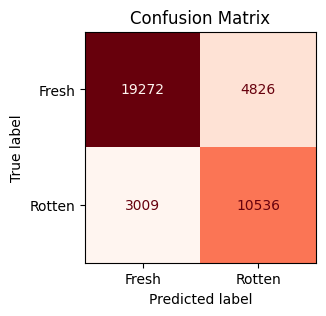

In [ ]:
y_pred_test_tfidf = lr_model_tfidf.predict(X_test_new)
y_test_org = le.inverse_transform(y_test_encoded)
y_pred_test_tfidf_org = le.inverse_transform(y_pred_test_tfidf)
y_pred_test_proba = lr_model_tfidf.predict_proba(X_test_new)[:,1]

roc_auc_tfidf_test = roc_auc_score(y_test_encoded, y_pred_test_proba)
accuracy_score_tfidf_test = accuracy_score(y_test_encoded, y_pred_test_tfidf)
precision_score_tfidf_test = precision_score(y_test_encoded, y_pred_test_tfidf)
recall_score_tfidf_test = recall_score(y_test_encoded, y_pred_test_tfidf)
f1_score_tfidf_test = f1_score(y_test_encoded, y_pred_test_tfidf)
print('TFIDF AUC Score: ', roc_auc_tfidf_test ,'TFIDF Accuracy Score: ',accuracy_score_tfidf_test,'TFIDF Precision Score: ',precision_score_tfidf_test,'TFIDF Recall Score: ',recall_score_tfidf_test,'TFIDF Validation F1 Score: ', f1_score_tfidf_test )

cm_tfidf = confusion_matrix(y_test_encoded,y_pred_test_tfidf)
plot_cm(cm_tfidf,'Reds')

1177/1177 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
GRU AUC Score:  0.897074853478357 GRU Accuracy Score:  0.823154371330659 GRU Precision Score:  0.7663573085846868 GRU Recall Score:  0.7315614617940199 GRU F1 Score:  0.7485552407932011
              precision    recall  f1-score   support

       Fresh       0.85      0.87      0.86     24098
      Rotten       0.77      0.73      0.75     13545

    accuracy                           0.82     37643
   macro avg       0.81      0.80      0.81     37643
weighted avg       0.82      0.82      0.82     37643



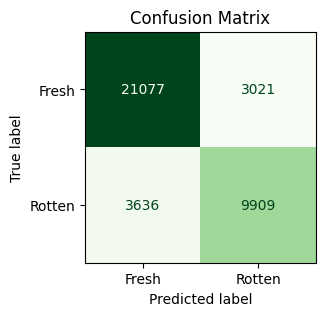

In [ ]:
y_pred_test_gru_prob = model.predict(X_test_pad)
y_pred_test_gru = (y_pred_test_gru_prob>0.5).astype(int)

y_test_org_gru = le.inverse_transform(y_test_encoded)
y_pred_test_gru_org = le.inverse_transform(y_pred_test_gru.reshape(-1))
cm_gru = confusion_matrix(y_test_encoded,y_pred_test_gru.reshape(-1))
y_pred_test_gru_flat = y_pred_test_gru.reshape(-1)

roc_auc_gru_test = roc_auc_score(y_test_encoded, y_pred_test_gru_prob)
accuracy_score_gru_test = accuracy_score(y_test_encoded, y_pred_test_gru_flat)
precision_score_gru_test = precision_score(y_test_encoded, y_pred_test_gru_flat)
recall_score_gru_test = recall_score(y_test_encoded, y_pred_test_gru_flat)
f1_score_gru_test = f1_score(y_test_encoded, y_pred_test_gru_flat)

print('GRU AUC Score: ', roc_auc_gru_test ,'GRU Accuracy Score: ',accuracy_score_gru_test,'GRU Precision Score: ',precision_score_gru_test,'GRU Recall Score: ',recall_score_gru_test,'GRU F1 Score: ', f1_score_gru_test )
plot_cm(cm_gru,'Greens')

Bert AUC Score:  0.9528216899242575 Bert Accuracy Score:  0.8822623064049093 Bert Precision Score:  0.8022954952564187 Bert Recall Score:  0.8928017718715393 Bert F1 Score:  0.8451324341323643
              precision    recall  f1-score   support

           0       0.94      0.88      0.91     24098
           1       0.80      0.89      0.85     13545

    accuracy                           0.88     37643
   macro avg       0.87      0.88      0.88     37643
weighted avg       0.89      0.88      0.88     37643



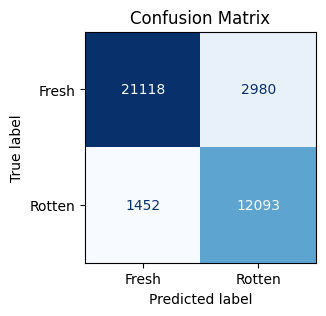

In [ ]:
preds_output_test = trainer.predict(tokenized_test_dataset)
pred_test = np.argmax(preds_output_test.predictions, axis = 1)
true_labels_test = preds_output_test.label_ids
probs_test = preds_output_test.predictions
probs_softmax_test = torch.softmax(torch.tensor(probs_test), dim = 1).numpy()[:,1]
cm_bert = confusion_matrix(true_labels_test,pred_test)
roc_auc_score_bert_test = roc_auc_score(true_labels_test,probs_softmax_test)
accuracy_score_bert_test = accuracy_score(true_labels_test,pred_test)
precision_score_bert_test = precision_score(true_labels_test,pred_test,zero_division = 0)
recall_score_bert_test = recall_score(true_labels_test,pred_test,zero_division = 0)
f1_score_bert_test = f1_score(true_labels_test,pred_test,zero_division = 0)
print('Bert AUC Score: ', roc_auc_score_bert_test ,'Bert Accuracy Score: ',accuracy_score_bert_test,'Bert Precision Score: ',precision_score_bert_test,'Bert Recall Score: ',recall_score_bert_test,'Bert F1 Score: ', f1_score_bert_test)
plot_cm(cm_bert,'Blues')

| Model Used | Test Accuracy Score | Test Recall Score | Test Precision Score | Test F1 Score | Test ROC-AUC Score |
|-----|----|---|---|----|-----|
| TFIDF + Logistic Regression | 0.7919 | 0.7789 | 0.6858 | 0.7290 | 0.8719 |
| GRU Model + Sigmoid Final Layer (Logistic Regression) | 0.8232 | 0.7316 | 0.7664 | 0.7486 | 0.8971 |
| Bert Model | 0.8823 | 0.8928 | 0.8023 | 0.8451 | 0.9528 |


### Evaluation

As the data was imbalanced, the best evaluation metric to compare all the models is F1-Score. For both the validation and test sets the BERT model outperforms all the other models in all the evaluation metrics as it's contexual embedding helps it to understand sentiment effectively. The GRU model performs moderately and struggles because the average length of each sentence is too short for it to understand sequence dependancies. The TF-IDF model performs the worst as it cannot capture sequential and contexual information.

# Final Discussion

### Overall Strengths

1. The BERT model achieves a high score in all evaluation metrics on both the validation and test sets, which makes it efficient for sentiment analysis on unseen data.
2. All the models are able to overcome class imbalance by striking a balance in between precision and recall.

### Overall Weaknesses

1. BERT model takes a lot of computational power and takes a long time to run.
2. Sequence based models like the GRU model have lower scores due to the word lengths being too less.

### Business Implications

1. The model allows fast identification of movie reviews if they are positively viewed or negatively viewed.
2. Reduces costs by removing the need for manual sentiment analysis.
3. Helps in decision making for content acquisition, promotion and recommendation strategies.

### Business Recommendations

1. Adopt BERT as the model for performing the sentiment analysis task.
2. Train on more data to improve the overall performance of the model.
3. Train the model periodically with newer critic reviews to maintain the performance of the model.

